In [2]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

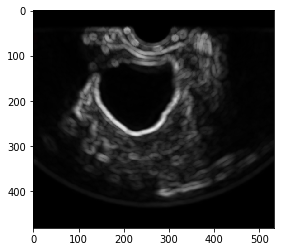

In [14]:
img = cv2.imread('E:\\dataset\\train\\simple.1.jpg')
blur = cv2.GaussianBlur(img, (7, 7), 2)
h, w = img.shape[:2]

# Morphological gradient

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
gradient = cv2.morphologyEx(blur, cv2.MORPH_GRADIENT, kernel)
plt.imshow(gradient)

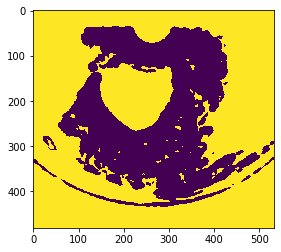

In [15]:
lowerb = np.array([0, 0, 0])
upperb = np.array([15, 15, 15])
binary = cv2.inRange(gradient, lowerb, upperb)
plt.imshow(binary)

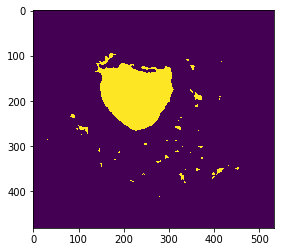

In [16]:
for row in range(h):
    if binary[row, 0] == 255:
        cv2.floodFill(binary, None, (0, row), 0)
    if binary[row, w-1] == 255:
        cv2.floodFill(binary, None, (w-1, row), 0)

for col in range(w):
    if binary[0, col] == 255:
        cv2.floodFill(binary, None, (col, 0), 0)
    if binary[h-1, col] == 255:
        cv2.floodFill(binary, None, (col, h-1), 0)

plt.imshow(binary)

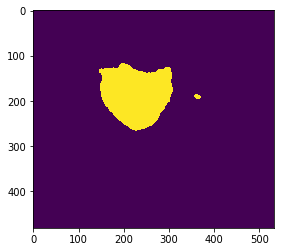

In [17]:
# Cleaning up mask

foreground = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
foreground = cv2.morphologyEx(foreground, cv2.MORPH_CLOSE, kernel)
plt.imshow(foreground)

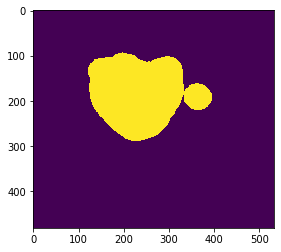

In [18]:
# Creating background and unknown mask for labeling

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (17, 17))
background = cv2.dilate(foreground, kernel, iterations=3)
unknown = cv2.subtract(background, foreground)
plt.imshow(background)
#cv2.waitKey()

In [19]:
# Watershed

markers = cv2.connectedComponents(foreground)[1]
markers += 1  # Add one to all labels so that background is 1, not 0
markers[unknown==255] = 0  # mark the region of unknown with zero
markers = cv2.watershed(img, markers)

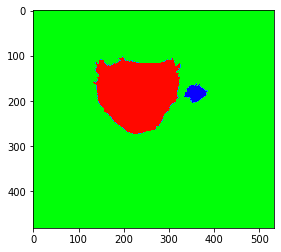

In [20]:
# Assign the markers a hue between 0 and 179

hue_markers = np.uint8(179*np.float32(markers)/np.max(markers))
blank_channel = 255*np.ones((h, w), dtype=np.uint8)
marker_img = cv2.merge([hue_markers, blank_channel, blank_channel])
marker_img = cv2.cvtColor(marker_img, cv2.COLOR_HSV2BGR)
plt.imshow(marker_img)
#cv2.waitKey()

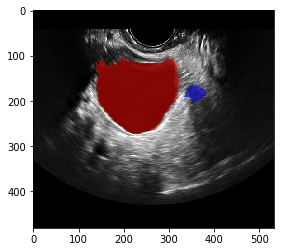

In [21]:
# Label the original image with the watershed markers

labeled_img = img.copy()
labeled_img[markers>1] = marker_img[markers>1]  # 1 is background color
labeled_img = cv2.addWeighted(img, 0.5, labeled_img, 0.5, 0)
plt.imshow(labeled_img)
#cv2.waitKey()